# Validate automatic irrigated crop area maps

**What does this notebook do?** This notebook calculates confusion matrix statistics for the automatically generated irrigated crop extent geotiff. The results can be used to validate the accuracy of the automatic process.

**Inputs**
- Max NDVI geotiff
- Validation mask of irrigated crop area, as a .pkl file

**Date:** May 2018

**Author:** Claire Krause

In [1]:
%pylab notebook

import pickle
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


## Set up the notebook

In [2]:
year = '2013'

In [3]:
StatsFile = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/AutoIrrigated_0.8_{0}.tif'.format(year)

In [4]:
# NSW validation mask
maskFile = 'NSWDOIwaterMask_{0}.pkl'.format(year)

## Load in the data

In [5]:
# Open the Geotiff
GeotiffData = xr.open_rasterio(StatsFile)

In [6]:
# Open the pickled mask
with open(maskFile, 'rb') as f:
    mask = pickle.load(f)

## Generate boolean masks for both the automatic crop extent, and the validation mask

In [7]:
ValidationMaskBoolean = np.isfinite(mask)

In [8]:
AutomaticCropBoolean = np.isfinite(GeotiffData)

## Compare our two masks to generate a confusion matrix

In [9]:
YesRealYesAuto = np.logical_and(AutomaticCropBoolean, ValidationMaskBoolean)
NoRealNoAuto = np.logical_and(~AutomaticCropBoolean, ~ValidationMaskBoolean)

YesRealNoAuto = np.logical_and(AutomaticCropBoolean, ~ValidationMaskBoolean)
NoRealYesAuto = np.logical_and(~AutomaticCropBoolean, ValidationMaskBoolean)

N.B `92799935` is the number of NaN pixels caused by the shape of the polygon being treated as a square. These pixels have been removed to provide a more accurate representation of the actual performance of the classification.

In [10]:
Correct_positives = YesRealYesAuto.sum()
Incorrect_positives = NoRealYesAuto.sum()
Correct_negatives = NoRealNoAuto.sum()  - 92799935
Incorrect_negatives = YesRealNoAuto.sum()

Totalpixels = (ValidationMaskBoolean.x.size * ValidationMaskBoolean.y.size) - 92799935

### Confusion Matrix Rates

| Metric | Description | Formula | AKA | 
|---|---|---|---|
| Accuracy | Overall, how often is the classifier correct? | (CP + CN) / total | | 
| Misclassification Rate | Overall, how often is it wrong? | (IP + IN) / total | Error Rate | 
| True Positive Rate | When it's actually yes, how often does it predict yes? | CP / actual yes | Sensitivity or Recall|
| False Positive Rate | When it's actually no, how often does it predict yes? | CP / actual no | | 
| Specificity | When it's actually no, how often does it predict no? | CN / actual no | | 
| Precision | When it predicts yes, how often is it correct? | CP / predicted yes | | 
| Prevalence | How often does the yes condition actually occur in our sample? | actual yes / total | | 

In [11]:
Accuracy = (Correct_positives + Correct_negatives) / Totalpixels
Misclassification_rate = (Incorrect_positives + Incorrect_negatives) / Totalpixels
True_Positive_Rate = Correct_positives / ValidationMaskBoolean.sum()
False_Positive_Rate = Correct_positives / ((~ValidationMaskBoolean).sum())
Specificity = Correct_negatives / ((~ValidationMaskBoolean).sum())
Precision = Correct_positives / AutomaticCropBoolean.sum()
Prevalence = (ValidationMaskBoolean.sum() ) / Totalpixels

print('\033[1m' + '{0} Automatic Irrigated Crop Extent'.format(year) + '\033[0m')

print('Accuracy = %.2f' % Accuracy.values)
print('Misclassification_rate = %.2f' % Misclassification_rate.values)
print('True_Positive_Rate = %.2f' % True_Positive_Rate.values)
print('False_Positive_Rate = %.2f' % False_Positive_Rate.values)
print('Specificity = %.2f' % Specificity.values)
print('Precision = %.2f' % Precision.values)
print('Prevalence = %.2f' % Prevalence.values)

2013 Automatic Irrigated Crop Extent
Accuracy = 0.99
Misclassification_rate = 0.01
True_Positive_Rate = 0.66
False_Positive_Rate = 0.00
Specificity = 0.41
Precision = 0.64
Prevalence = 0.01


<IPython.core.display.Javascript object>


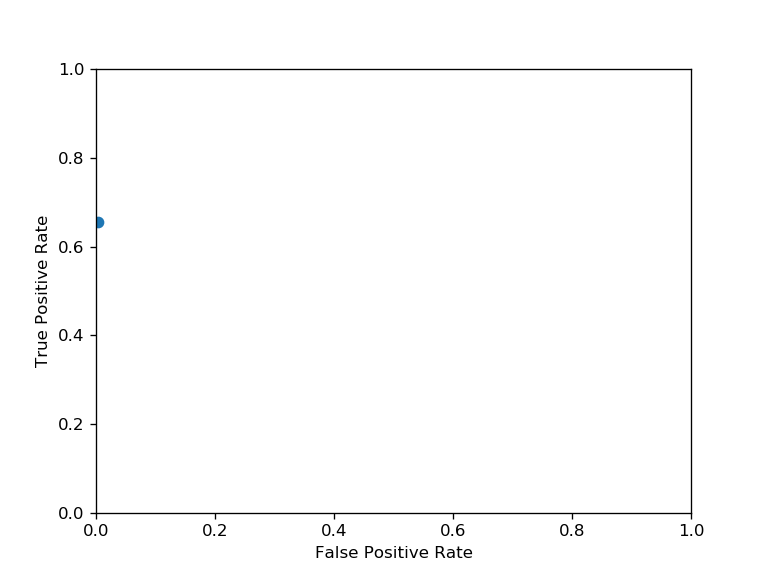

In [12]:
plt.figure()
plt.scatter(False_Positive_Rate, True_Positive_Rate)
plt.xlim ([0, 1]);
plt.ylim ([0, 1]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');